In [1]:
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

def show_adn_save(file_name,img):
    npimg = np.transpose(img.numpy(),(1,2,0))
    f = "./%s.png" % file_name
    plt.imshow(npimg)
    plt.imsave(f,npimg)

In [3]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size)

In [12]:
# Creating the architecture of the Neural Network
class RBM(nn.Module):
    def __init__(self, nv=784 , nh=500, k=5):
        #Initialize Weight and bias for visible nodes and hidden nodes
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(nh,nv)*1e-2)
        self.b = nn.Parameter(torch.zeros(nv))
        self.a = nn.Parameter(torch.zeros(nh))
        self.k = k

    def sample_h(self, x):
        #Gibb's sampling of hidden nodes from visible nodes (MCMC)
        activation = F.linear(x,self.W,self.a)
        p_h_given_v = F.sigmoid(activation)    
        return p_h_given_v, torch.bernoulli(p_h_given_v)

    
    def sample_from_p(self,p):
        return F.relu(torch.sign(p - Variable(torch.rand(p.size()))))
    
    def sample_v(self, y):
        #Gibb's sampling of visible nodes from hidden nodes (MCMC)
        activation = F.linear(y,self.W.t(),self.b)
        p_v_given_h = F.sigmoid(activation)
        return p_v_given_h, torch.bernoulli(p_v_given_h)

    def free_energy(self,v):
        #EF(v)=−bTv−∑jlog(1+exp(a+WTv))j
        vbias_term = v.mv(self.b)
        wx_b = F.linear(v,self.W,self.a)
        hidden_term = wx_b.exp().add(1).log().sum(1)
        return (-hidden_term - vbias_term).mean()
    
    def forward(self,v):
        #Train and update weight and bias by k-steps Contrastive Divergence, as describe in originsl Hinton's paper : http://www.cs.toronto.edu/~fritz/absps/tr00-004.pdf
        #https://lions.epfl.ch/files/content/sites/lions2/files/Documents/Reading%20Group%20Notes/papers/AItRBM-proof-3.pdf
        pre_h1,h1 = self.sample_h(v)
        
        h_ = h1
        for _ in range(self.k):
            pre_v_,v_ = self.sample_v(h_)
            pre_h_,h_ = self.sample_h(v_)
        
        return v,v_
    



In [13]:
rbm = RBM(k=1)

In [14]:
model = optim.SGD(rbm.parameters(),lr=0.1)

In [15]:
# Training the RBM
for epoch in range(10):
    loss_ = []
    for _, (data,target) in enumerate(train_loader):
        data = Variable(data.view(-1,784))
        
        sample_data = data.bernoulli()
        v,vk = rbm(sample_data)
        loss = rbm.free_energy(v) - rbm.free_energy(vk)
        loss_.append(loss.data[0])
        model.zero_grad()
        loss.backward()
        model.step()
    
    print (np.mean(loss_))

-8.41328386254
-6.61848505016
-4.58305550842
-3.16536525572
-2.18900791973
-1.54741966394
-1.06479799315
-0.721768214504
-0.542670276373
-0.281826125025


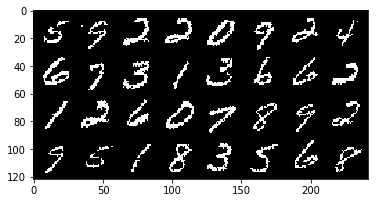

In [16]:
show_adn_save("real",make_grid(v.view(32,1,28,28).data))

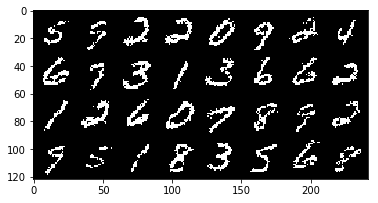

In [18]:
show_adn_save("gen",make_grid(vk.view(32,1,28,28).data))